<a href="https://colab.research.google.com/github/AhmedAbdallah142/16bit-processor-code/blob/main/assignment_3_2_pr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install tensorflow-io
import os
import tarfile
import librosa
import scipy.io
import scipy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import opendatasets as od
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import sklearn.metrics as metrics
from glob import glob
from numpy import linalg
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#----------------------------------------------------
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight

     |████████████████████████████████| 25.9 MB 4.9 MB/s 
     |████████████████████████████████| 2.4 MB 34.7 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.25.0
    Uninstalling tensorflow-io-gcs-filesystem-0.25.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [2]:
od.download("https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmedabdallah142
Your Kaggle Key: ··········


100%|██████████| 987M/987M [00:04<00:00, 228MB/s]


In [3]:
def LoadAudio(dir_path):
    emotions = []
    data=[]

    for audio in os.listdir(dir_path):
        path = dir_path + audio
        temp , sr = librosa.load(path,sr=16000)
        wav, index = librosa.effects.trim(temp, top_db=60)       
        

        if len(wav) > (3*16000):
            wav = wav[:3*16000]
        else:
            padding = (3*16000) - len(wav)
            offset = padding // 2
            wav = np.pad(wav, (offset,3*16000- len(wav) - offset), 'constant') 

        mean = np.mean(wav)
        std = np.std(wav)
        out = np.ones( (len(wav)) ) 
        wav= np.divide((wav - mean),std,out=out, where=std!=0)#normalization & standarization
        
        data.append(wav)
        
        emotion = path.split('_')
        if emotion[2] == 'SAD':
            emotions.append(0)
        elif emotion[2] == 'ANG':
            emotions.append(1)
        elif emotion[2] == 'DIS':
            emotions.append(2)
        elif emotion[2] == 'NEU':
            emotions.append(3)
        elif emotion[2] == 'HAP':
            emotions.append(4)
        elif emotion[2] == 'FEA':
            emotions.append(5)
        else:
            emotions.append(6)
            
    return data,emotions

In [4]:
data,Labels =  LoadAudio('./speech-emotion-recognition-en/Crema/')
print(len(data))
print(len(Labels))

7442
7442


In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(data,Labels, test_size=0.30, random_state=42)
train_data,val_data, train_labels, val_labels = train_test_split(train_data,train_labels, test_size=0.05, random_state=42)
print(len(train_data))
print(len(val_data))
print(len(test_data))

4948
261
2233


In [6]:
def mel_spectrogram_features(data):   
    temp = librosa.feature.melspectrogram(y=data, sr=16000, n_mels=128)
    mel_spec_db=librosa.power_to_db(temp, ref=np.max)
    return mel_spec_db

In [7]:
def extract_mel_spectrogram_features(data):
    set_spectorgram = np.zeros((len(data),128,94)) 
    for i in range(len(data)):
          set_spectorgram[i]= mel_spectrogram_features(data[i])
    return set_spectorgram

In [8]:
train_set_spectorgram = extract_mel_spectrogram_features(train_data)
val_set_spectorgram   = extract_mel_spectrogram_features(val_data)
test_set_spectorgram  = extract_mel_spectrogram_features(test_data)

In [ ]:
def specAug(data,label):
  dataSize = len(data)
  for i in range(dataSize):
    mask = data[i].mean()
    data = np.append(data,[tfio.audio.freq_mask(data[i], param=mask)],axis=0)
    label.append(label[i])
    data = np.append(data,[tfio.audio.time_mask(data[i], param=mask)],axis=0)
    label.append(label[i])
  return data
train_set_spectorgram = specAug(train_set_spectorgram,train_labels)

In [ ]:
print(len(train_set_spectorgram))

9896


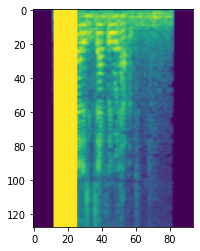

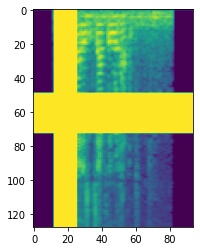

In [ ]:
freq_mask = tfio.audio.freq_mask(train_set_spectorgram[1], param=25)
time_mask = tfio.audio.time_mask(freq_mask, param=25)

plt.figure()
plt.imshow(freq_mask.numpy())

plt.figure()
plt.imshow(time_mask.numpy())

In [9]:
train_set_spectorgram = train_set_spectorgram[:,:,:,np.newaxis]
print(train_set_spectorgram.shape)
val_set_spectorgram = val_set_spectorgram[:,:,:,np.newaxis]
print(val_set_spectorgram.shape)
test_set_spectorgram = test_set_spectorgram[:,:,:,np.newaxis]
print(test_set_spectorgram.shape)

(4948, 128, 94, 1)
(261, 128, 94, 1)
(2233, 128, 94, 1)


In [18]:
CNNmodel = Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(train_set_spectorgram.shape[1],train_set_spectorgram.shape[2],1)))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
CNNmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 92, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 46, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 46, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 44, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 30, 22, 64)       

In [19]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=30, verbose=1, mode='auto')
model_history = CNNmodel.fit(np.array(train_set_spectorgram),np.array(train_labels),batch_size=32,epochs=100,validation_data=(np.array(val_set_spectorgram), np.array(val_labels)),callbacks=[checkpoint,early])
CNNmodel = load_model("model.h5")
score, acc = CNNmodel.evaluate(np.array(val_set_spectorgram), np.array(val_labels), verbose=0)
print('Val accuracy:', acc)

Epoch 1/100
155/155 [==============================] - ETA: 0s - loss: 2.1681 - accuracy: 0.1544
Epoch 1: val_accuracy improved from -inf to 0.16475, saving model to model.h5
155/155 [==============================] - 3s 17ms/step - loss: 2.1681 - accuracy: 0.1544 - val_loss: 2.2034 - val_accuracy: 0.1648
Epoch 2/100
153/155 [============================>.] - ETA: 0s - loss: 1.8287 - accuracy: 0.1801
Epoch 2: val_accuracy improved from 0.16475 to 0.19540, saving model to model.h5
155/155 [==============================] - 2s 15ms/step - loss: 1.8288 - accuracy: 0.1797 - val_loss: 2.1219 - val_accuracy: 0.1954
Epoch 3/100
153/155 [============================>.] - ETA: 0s - loss: 1.8032 - accuracy: 0.1895
Epoch 3: val_accuracy did not improve from 0.19540
155/155 [==============================] - 2s 14ms/step - loss: 1.8033 - accuracy: 0.1902 - val_loss: 2.0849 - val_accuracy: 0.1916
Epoch 4/100
153/155 [============================>.] - ETA: 0s - loss: 1.7510 - accuracy: 0.2306
Epoch 

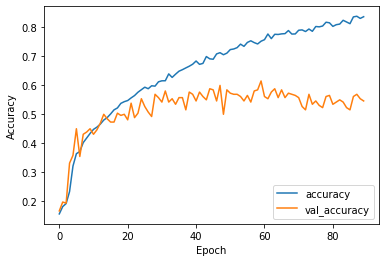

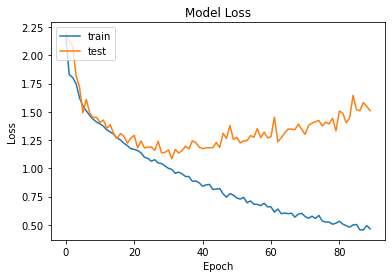

In [20]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

           0       0.51      0.50      0.51       359
           1       0.64      0.77      0.70       390
           2       0.55      0.36      0.43       395
           3       0.56      0.72      0.63       320
           4       0.55      0.46      0.50       370
           5       0.48      0.52      0.50       399

    accuracy                           0.55      2233
   macro avg       0.55      0.56      0.54      2233
weighted avg       0.55      0.55      0.54      2233

[[180   3  27  67   5  77]
 [  0 299  29  12  32  18]
 [ 60  70 142  46  35  42]
 [ 27   7  15 232  21  18]
 [ 13  65  22  33 170  67]
 [ 70  23  24  28  47 207]]
val accuracy: 61.302679777145386
train accuracy: 89.95553851127625
test accuracy 55.08284818629646


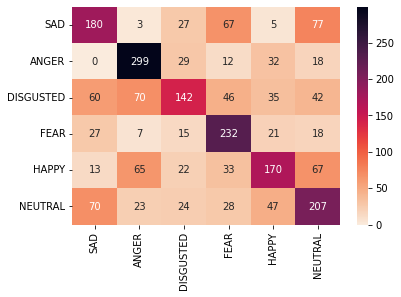

In [21]:
score, trainacc = CNNmodel.evaluate(np.array(train_set_spectorgram), np.array(train_labels), verbose=0)
y_pred = CNNmodel.predict(test_set_spectorgram)
report=metrics.classification_report(test_labels,np.argmax(y_pred,axis=1)) 
print(report)

matrix = metrics.confusion_matrix(test_labels ,np.argmax(y_pred,axis=1))
sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r',xticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'],yticklabels = ['SAD','ANGER','DISGUSTED','FEAR','HAPPY','NEUTRAL'])
print(matrix)

print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(test_labels,np.argmax(y_pred,axis=1))*100)